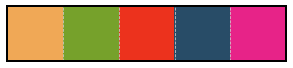

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import seaborn as sns
import copy
import math
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : True})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})

colors = ['#F0A856', '#76A12B', '#EC321D', '#284C67', '#E72388']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
line_style = dict(linewidth = 2, markersize = 8, err_style = "bars",)

sub_figure_title = {"fontweight": 700, 'fontname':'Times New Roman', 'fontsize': 18}
markers = {"MemoryMode": "s", "TupleCache": "v", "AlchemyTuple": "^", "AlchemySync": "<", "Alchemy": ">", "PMem": "p", "DRAM": "P"}

In [2]:
def load_data(bench_dir):
    files = os.listdir(bench_dir)
    bench_data = []
    for f in files:
        data = json.load(open(f'{bench_dir}/{f}'))

        for b in data["run"]:
            n_data = data.copy()
            if b["pcm"]:
                b["pcm"] = b["pcm"][0]
            n_data["run"] = b

            for i in n_data["run"]["results"]:
                inner_d = n_data.copy()
                inner_d["run"]["results"] = i
                bench_data.append(inner_d)
    bench_data = pd.json_normalize(bench_data)
    return bench_data

hue_order = ["TupleCache", "AlchemyTuple", "AlchemySync", "Alchemy", "MemoryMode"]
markers = {"MemoryMode": "s", "TupleCache": "v", "AlchemyTuple": "^", "AlchemySync": "<", "Alchemy": ">", "PMem": "p", "DRAM": "P"}


# Basic performance

In [3]:
pd_basic = load_data("basic-02-05")

def label_basic(row):
	if row["config.name"] == "table-basic_alchemy":
		return "Alchemy"
	elif row["config.name"] == "table-basic_dram_only":
		return "DRAM"
	elif row["config.name"] == "table-basic_pm":
		return "PMem"
	elif row["config.name"] == "table-basic_mm":
		return "MemoryMode"
	else:
		return ""

def pm_total_bw(row):
	return row["run.pcm.pm_read"] + row["run.pcm.pm_write"]


def dram_total_bw(row):
	return row["run.pcm.dram_read"] + row["run.pcm.dram_write"]

pd_basic["config.label"] = pd_basic.apply(lambda x: label_basic(x), axis=1)
pd_basic["run.pcm.pm_total"] = pd_basic.apply(lambda x: pm_total_bw(x), axis=1)
pd_basic["run.pcm.dram_total"] = pd_basic.apply(lambda x: dram_total_bw(x), axis=1)

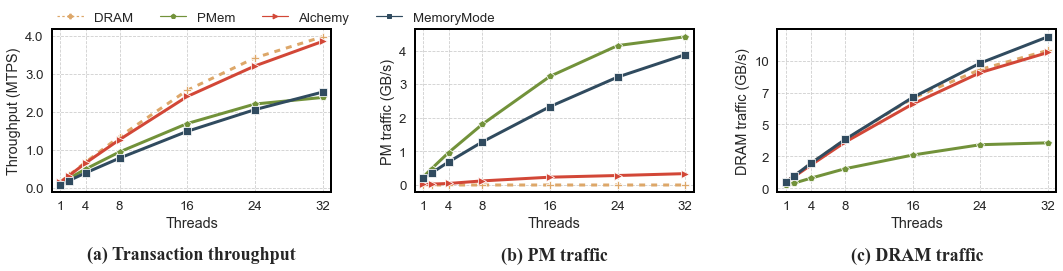

In [4]:
line_style_b = dict(linewidth = 3, markersize = 8, err_style = "bars")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3))
fig.subplots_adjust(wspace=0.3)
ax1 = sns.lineplot(ax=ax1, x="run.thread_cnt", y="run.results.commit", hue="config.label",
                  style = "config.label", dashes=[(2, 2), (), (), () ],
                  **line_style_b, data=pd_basic, markers=markers)
ax1.set(xlabel='Threads', ylabel='Throughput (MTPS)', xlim=(0,33))
ax1.legend(loc=(0,1), ncol=4, frameon=False).set_title("")
ax1.set_title("(a) Transaction throughput", y=-0.45, fontdict=sub_figure_title)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000}'))
ax1.xaxis.set_major_locator(ticker.FixedLocator([1,4,8,16,24,32]))


ax2 = sns.lineplot(ax=ax2, x="run.thread_cnt", y="run.pcm.pm_total", hue="config.label",
                   style="config.label", markers=markers, dashes=[(2, 2), (), (), ()],
                   **line_style_b, data=pd_basic)
ax2.legend().remove()
ax2.set(xlabel='Threads', ylabel='PM traffic (GB/s)', xlim=(0,33))
ax2.set_title("(b) PM traffic", y=-0.45, fontdict= sub_figure_title)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000000000)}'))
ax2.xaxis.set_major_locator(ticker.FixedLocator([1,4,8,16,24,32]))
ax2.yaxis.set_major_locator(ticker.FixedLocator([0, 1000000000,2000000000,3000000000,4000000000]))


ax3 = sns.lineplot(ax=ax3, x="run.thread_cnt", y="run.pcm.dram_total", hue="config.label",
                   style="config.label", markers=markers, dashes=[(2,2), (), (), ()],
                   **line_style_b, data=pd_basic)
ax3.legend().remove()
ax3.set(xlabel='Threads', ylabel='DRAM traffic (GB/s)', xlim=(0,33))
ax3.set_title("(c) DRAM traffic", y=-0.45, fontdict= sub_figure_title)
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000000000)}'))
ax3.xaxis.set_major_locator(ticker.FixedLocator([1,4,8,16,24,32]))

fig.savefig("./basic.pdf", bbox_inches='tight', pad_inches=0.1)


# Workload

In [5]:
pd_workload = load_data("workload-02-04")

def label_ratio(row):
	workload = row["config.workload"]
	if workload == "ReadOnly":
		return 0
	elif workload == "ReadHeavy":
		return 1
	elif workload == "Balanced":
		return 2
	elif workload == "WriteHeavy":
		return 3
	else:
		return 4

def label_workload(row):
	if row["config.policy"] == "Field" and row["config.mem_engine"] == "Async":
		return "Alchemy"
	elif row["config.policy"] == "Field" and row["config.mem_engine"] == "Sync":
		return "AlchemySync"
	elif row["config.policy"] == "Tuple" and row["config.mem_engine"] == "Async":
		return "AlchemyTuple"
	elif row["config.policy"] == "Tuple" and row["config.mem_engine"] == "Sync":
		return "TupleCache"
	elif row["config.policy"] == "Direct" and row["config.mem_engine"] == "Sync":
		return "Direct"
	else:
		print("Error: {}", row["config.name"])
		return ""



pd_workload["config.label"] = pd_workload.apply(lambda x: label_workload(x), axis=1)
pd_workload["config.read_ratio"] = pd_workload.apply(lambda x: label_ratio(x), axis=1)
pd_workload["run.pcm.pm_total"] = pd_workload.apply(lambda x: pm_total_bw(x), axis=1)
pd_workload = pd_workload.sort_values(by=['config.read_ratio'])
hue_order = ["TupleCache", "AlchemyTuple", "AlchemySync", "Alchemy"]

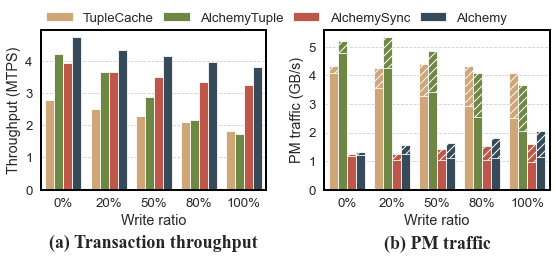

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
fig.tight_layout(w_pad=1.5)
ax1 = sns.barplot(ax=ax1, x="config.read_ratio", y="run.results.commit", hue="config.label", data=pd_workload,
hue_order=hue_order)
ax1.set(xlabel='Write ratio', ylabel='Throughput (MTPS)', title='')
ax1.set_title("(a) Transaction throughput", y=-0.4, fontdict=sub_figure_title)
ax1.legend(loc=(0,1), ncol=4, columnspacing=0.7, frameon=False).set_title("")
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}'))

ax1.set_xticklabels(['0%','20%','50%','80%','100%'])

ax2 = sns.barplot(ax=ax2, x="config.read_ratio", y="run.pcm.pm_total", hue="config.label",
                   data=pd_workload, hatch="///", hue_order=hue_order)
ax2 = sns.barplot(ax=ax2, x="config.read_ratio", y="run.pcm.pm_read", hue="config.label",
                   data=pd_workload, hue_order=hue_order)

ax2.legend().remove()
ax2.set(xlabel='Write ratio', ylabel='PM traffic (GB/s)')
ax2.set_title("(b) PM traffic", y=-0.4, fontdict=sub_figure_title)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000_000)}'))
ax2.set_xticklabels(['0%','20%','50%','80%','100%'])

fig.savefig("./workload.pdf", bbox_inches='tight', pad_inches=0.1)


# Cache size

In [7]:
pd_size = load_data("size-02-04")


def label_size_precent(row):
    cache_size = row["config.cache_size_mb"]
    if cache_size == 1400:
        return "10%"
    elif cache_size == 4200:
        return "30%"
    elif cache_size == 7000:
        return "50%"
    elif cache_size == 11200:
        return "80%"
    elif cache_size == 14000:
        return "100%"

def label_hit_ratio(row):
    return row["run.results.metrics.counters.read_hit"]/row["run.results.metrics.counters.read_cnt"]

def extrapolate_price(data):
    dram_price = data.loc[(data["run.thread_cnt"] == 32) & (data["config.label"] == "TupleCache") & (data["config.cache_precent"] == "100%")].copy()
    dram_price["config.data_size_mb"] = 0
    dram_price["config.price_pre_commit"] =  dram_price.apply(lambda x: calc_price(x)/x["run.results.commit"], axis =1)
    prices = pd.DataFrame()

    for i in ["10%", "30%", "50%", "80%", "100%"]:
        tmp = dram_price.copy()
        tmp["config.cache_precent"] = i
        tmp["config.label"] = "DRAM"
        prices = pd.concat([prices, tmp])

    return prices

dram_price = 7.431
pm_price = 4.56
def calc_price(row):
    return row["config.cache_size_mb"] / 1024 * dram_price +\
           row["config.data_size_mb"] / 1024 * pm_price

pd_size = pd_size.sort_values(by=['config.cache_size_mb'])
pd_size["config.label"] = pd_size.apply(lambda x: label_workload(x), axis=1)
pd_size["config.cache_precent"] = pd_size.apply(lambda x: label_size_precent(x), axis=1)
pd_size["config.hit_ratio"] = pd_size.apply(lambda x: label_hit_ratio(x), axis=1)
pd_size["run.pcm.pm_total"] = pd_size.apply(lambda x: pm_total_bw(x), axis=1)
pd_size["config.price_pre_commit"] = pd_size.apply(lambda x: calc_price(x)/x["run.results.commit"], axis =1)
hue_order = ["TupleCache", "AlchemyTuple", "AlchemySync", "Alchemy"]

/tmp/ipykernel_10138/387947537.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(cache_labels)


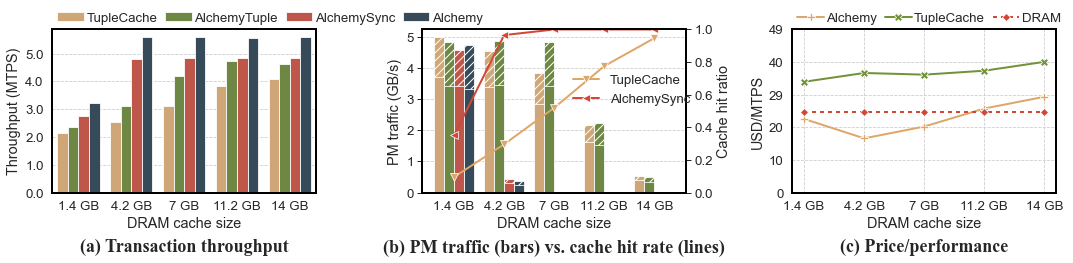

In [8]:
cache_labels = ["1.4 GB", "4.2 GB", "7 GB", "11.2 GB", "14 GB"]

fig, axes = plt.subplots(1, 3, figsize=(18,3))
fig.subplots_adjust(wspace=0.4)

# Figure (a)
ax = sns.barplot(ax=axes[0], x='config.cache_precent', y="run.results.commit",
                 hue="config.label", data=pd_size,
                 hue_order = hue_order)
ax.set_xticklabels(cache_labels)
ax.set(xlabel='DRAM cache size', ylabel='Throughput (MTPS)', title='')
ax.set_title("(a) Transaction throughput", y=-0.4, fontdict=sub_figure_title)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000}'))
ax.legend(loc=(0,1), ncol=4, columnspacing=0.6, handletextpad=0.2, frameon=False).set_title("")

# Figure (b)
ax = sns.barplot(ax=axes[1], x='config.cache_precent', y="run.pcm.pm_total",
                 hue="config.label", data=pd_size, hatch="///",
                 hue_order = hue_order)
ax = sns.barplot(ax=ax, x="config.cache_precent", y="run.pcm.pm_read", 
                 hue="config.label", data=pd_size, hue_order = hue_order)
ax.set(xlabel='DRAM cache size', ylabel='PM traffic (GB/s)', title='')
ax.set_xticklabels(cache_labels)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000000000)}'))

# Figure (b - lines)
line_style = dict(linewidth = 2, markersize = 8, err_style = "bars", dashes = False)
ax_1 = ax.twinx()
ax_1 = sns.lineplot(ax=ax_1, x="config.cache_precent", y="config.hit_ratio", hue="config.label",
                    data=pd_size, style="config.label", **line_style, markers=markers,
                    hue_order = ["TupleCache","", "AlchemySync", ""])
ax.legend().remove()
ax_1.legend(["TupleCache", "AlchemySync"], frameon=False, loc=(0.55, 0.5)).set_title("")
ax_1.set(ylabel='Cache hit ratio', xlabel="Cache precentage")
ax_1.set(ylim=(0,1))
ax_1.grid(False)
ax_1.set_xticklabels(cache_labels)
ax_1.set_title("(b) PM traffic (bars) vs. cache hit rate (lines)", y=-0.4, fontdict=sub_figure_title)

# Figure (c)

pd_dram_price = extrapolate_price(pd_size)
pd_price = pd.concat([pd_size, pd_dram_price])
pd_price.reset_index(inplace=True)

line_style = dict(linewidth = 2, markersize = 8, err_style = "bars")

ax_2 = sns.lineplot(ax=axes[2], x="config.cache_precent", y="config.price_pre_commit",
                    hue="config.label", style="config.label", **line_style,
                    hue_order = ["Alchemy", "TupleCache", "DRAM"],
                    markers=True, data = pd_price,
                    dashes=[(), (), (), (), (2,2)]
                    )
ax_2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:  f'{int(x*1000_000)}'))
ax_2.set(ylabel="USD/MTPS", ylim=(0, 5e-5), xlabel="DRAM cache size")
ax_2.legend(["Alchemy", "TupleCache", "DRAM"], loc=(0,1), ncol=3, columnspacing=0.6, handletextpad=0.2, frameon=False).set_title("")
ax_2.set_xticklabels(cache_labels)
ax_2.set_title("(c) Price/performance", y=-0.4, fontdict=sub_figure_title)


fig.savefig("./cache-size.pdf", bbox_inches='tight', pad_inches=0.1)

# Skew

In [18]:
pd_skew = load_data("skew-02-04")

def label_skew_order(row):
    skew = row["config.distribution"]
    
    if skew == "SelfSimilar01":
        return 0
    elif skew == "SelfSimilar02":
        return 1
    elif skew == "SelfSimilar03":
        return 2
    elif skew == "SelfSimilar04":
        return 3
    else:
        return 4

pd_skew["config.label"] = pd_skew.apply(label_workload, axis=1)
pd_skew["config.skew_order"] = pd_skew.apply(label_skew_order, axis=1)
pd_skew = pd_skew.sort_values(by=['config.skew_order'])
pd_skew["run.results.hit_ratio"] = pd_skew.apply(lambda x: x["run.results.metrics.counters.read_hit"]/x["run.results.metrics.counters.read_cnt"], axis=1)


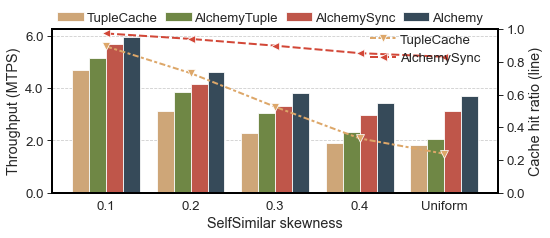

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))

ax = sns.barplot(ax= ax, x="config.distribution", y="run.results.commit", hue="config.label", data=pd_skew,
            hue_order=hue_order)
ax.set_xticklabels(['0.1','0.2','0.3','0.4','Uniform'])
ax.set(xlabel='SelfSimilar skewness', ylabel='Throughput (MTPS)', title='')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000}'))
ax.legend(loc=(0,1), ncol=4, columnspacing=0.6, handletextpad=0.2, frameon=False).set_title("")

ax_1 = ax.twinx()
ax_1 = sns.lineplot(ax=ax_1, x="config.skew_order", y="run.results.hit_ratio", hue="config.label",
                    style="config.label", data=pd_skew, **line_style, markers =markers,
                    hue_order=["TupleCache", "", "AlchemySync", ""])
ax_1.legend(["TupleCache", "AlchemySync"], columnspacing=0.6, handletextpad=0.3, loc=(0.7, 0.75), frameon=False).set_title("")
ax_1.set(ylabel='Cache hit ratio (line)')
ax_1.set(ylim=(0, 1))
ax_1.grid(False)

fig.savefig("./skew.pdf", bbox_inches='tight', pad_inches=0.1)


# Cache replacement cost

In [20]:
pd_replace = load_data("replacement-02-04")


def extrapolate_direct(data):
    uniform_sync = data[np.logical_and(data["config.distribution"] == "Uniform",
                                    data["config.label"] == "Direct")]
    uniform = pd.DataFrame()

    for i in [0.1, 0.2, 0.4, 0.8]:
        tmp = uniform_sync.copy()
        tmp["config.probe_rng"] = i 
        uniform = pd.concat([uniform, tmp])

    ss_sync = data[np.logical_and(data["config.distribution"] == "SelfSimilar02",
                                    data["config.label"] == "Direct")]
    ss = pd.DataFrame()
    for i in [0.1, 0.2, 0.4, 0.8]:
        tmp = ss_sync.copy()
        tmp["config.probe_rng"] = i 
        ss = pd.concat([ss, tmp])
    return uniform, ss
    

pd_replace["config.label"] = pd_replace.apply(label_workload, axis=1)

pd_d_uniform, pd_d_ss = extrapolate_direct(pd_replace)
pd_replace = pd.concat([pd_replace, pd_d_uniform, pd_d_ss])
pd_replace.reset_index(inplace=True)

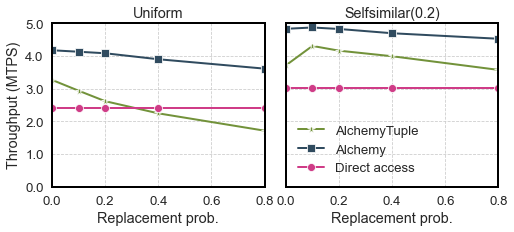

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1)

sns.lineplot(ax=axes[0], x="config.probe_rng", y="run.results.commit", hue="config.label", 
              **line_style, style="config.label",
             markers={"AlchemyTuple": "*", "Alchemy": "s", "Direct": "o"},
             hue_order=[*hue_order, "Direct"],
			 dashes=[(), (), ()],
             data=pd_replace[pd_replace["config.distribution"]=="Uniform"])

sns.lineplot(ax=axes[1], x="config.probe_rng", y="run.results.commit", hue="config.label", 
              **line_style, style = "config.label",
             markers={"AlchemyTuple": "*", "Alchemy": "s", "Direct": "o"},
             hue_order=[*hue_order, "Direct"],
			 dashes=[(), (), ()],
             data=pd_replace[pd_replace["config.distribution"]=="SelfSimilar02"])

axes[0].set(xlim=(0, 0.8), ylim=(0, 5e6), xlabel='Replacement prob.', ylabel='Throughput (MTPS)', title='Uniform')

axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000}'))
axes[1].set(xlim=(0,0.8), xlabel='Replacement prob.', ylabel='', title='Selfsimilar(0.2)')

axes[1].legend(["AlchemyTuple", "Alchemy", 'Direct access'], frameon=False).set_title("")
axes[0].legend().remove()

fig.savefig("./replacement.pdf", bbox_inches='tight', pad_inches=0.1)

# Latency

In [29]:
pd_latency = load_data("basic-latency-02-04")

def label_lat(row):
	if row["config.name"] == "table-basic_mm_latency":
		return "MemoryMode"
	elif row["config.policy"] == "Field" and row["config.mem_engine"] == "Async":
		return "Alchemy"
	elif row["config.policy"] == "Field" and row["config.mem_engine"] == "Sync":
		return "AlchemySync"
	elif row["config.policy"] == "Tuple" and row["config.mem_engine"] == "Async":
		return "AlchemyTuple"
	elif row["config.policy"] == "Tuple" and row["config.mem_engine"] == "Sync":
		return "TupleCache"
	else:
		print("Error: {}", row["config.name"])
		return ""

pd_latency["config.label"] = pd_latency.apply(label_lat, axis=1)
pd_latency = pd_latency.explode("run.results.metrics.timers.read").reset_index(drop=True)

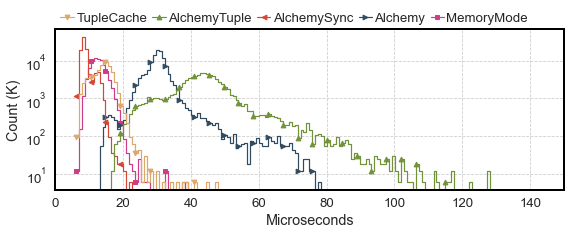

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))
fig.tight_layout()
ax = sns.histplot(ax=ax, x="run.results.metrics.timers.read", hue="config.label", bins=15000, element="step", fill=False,
                  hue_order = ["TupleCache", "AlchemyTuple", "AlchemySync", "Alchemy", "MemoryMode"],
                  data=pd_latency)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}'))
ax.set(xlim=(0,150_000), xlabel='Microseconds', ylabel='Count (K)', title='')
ax.set_yscale("log")


old_legend = ax.legend_
handles = old_legend.legendHandles
all_texts = old_legend.get_texts()
labels = [t.get_text() for t in all_texts]
for i, line in enumerate(handles):
    line.set_marker(markers[all_texts[i].get_text()])
ax.legend(handles, labels, loc=(0, 1), title="", ncol=5, columnspacing=0.4, handlelength=1, handletextpad=0.2, frameon=False).set_title("")

# This is hardcode order, I don't know how to figure out the order of lines...
marker_order = ["s", ">", "<", "^", "v"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(marker_order[i])
    line.set_markevery(5)

fig.savefig("./latency.pdf", bbox_inches='tight', pad_inches=0.1)

In [32]:
def get_quantile(data, label):
    data = data[data["config.label"] == label]
    data = data["run.results.metrics.timers.read"]
    print(f"{label}:\n {data.quantile([.5, .9, .95, 0.99, 0.999])}")

get_quantile(pd_latency, "TupleCache")
get_quantile(pd_latency, "AlchemyTuple")
get_quantile(pd_latency, "AlchemySync")
get_quantile(pd_latency, "Alchemy")
get_quantile(pd_latency, "MemoryMode")

TupleCache:
 0.500    14181.0
0.900    17186.0
0.950    18102.0
0.990    20562.0
0.999    27954.0
Name: run.results.metrics.timers.read, dtype: object
AlchemyTuple:
 0.500     43375.0
0.900     55087.0
0.950     63973.0
0.990     82992.0
0.999    107856.0
Name: run.results.metrics.timers.read, dtype: object
AlchemySync:
 0.500     8471.5
0.900    11931.0
0.950    12834.0
0.990    14221.0
0.999    17299.0
Name: run.results.metrics.timers.read, dtype: object
Alchemy:
 0.500    30212.0
0.900    34514.0
0.950    37815.0
0.990    56067.0
0.999    71199.0
Name: run.results.metrics.timers.read, dtype: object
MemoryMode:
 0.500     12552.0
0.900     15564.0
0.950    16576.05
0.990    18589.23
0.999     22761.0
Name: run.results.metrics.timers.read, dtype: object


# Async group size

In [15]:
pd_group = load_data("group_size-02-05")

def cal_99_latency(data):
	lat = data["run.results.metrics.timers.read"]
	lat = pd.Series(lat)
	return lat.quantile(0.99)

pd_group["run.results.metrics.lat_99"] = pd_group.apply(lambda x: cal_99_latency(x), axis=1)
pd_group = pd_group.explode("run.results.metrics.timers.read").reset_index(drop=True)
pd_group["load.async_group_size_str"] = pd_group["load.async_group_size"].astype(str)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


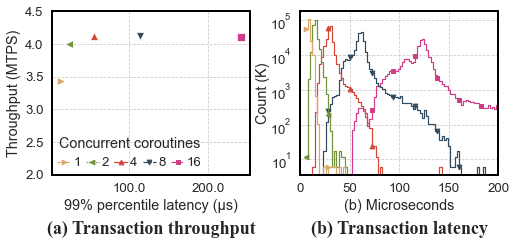

In [16]:
markers = {"1": ">", "2": "<", "4": "^", "8": "v", "16": "s"}

fig, axes = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.25)
ax = sns.lineplot(ax=axes[0], x="run.results.metrics.lat_99", y="run.results.commit", 
                     hue_order=["1", "2", "4", "8", "16"],
                     hue="load.async_group_size_str",
                     style="load.async_group_size_str",
             	     data=pd_group,
                     markers=markers,
                     **line_style,
                     )
ax.set(ylim=(2_000_000, 4_500_000), xlabel='99% percentile latency (μs)', ylabel='Throughput (MTPS)', title='')
ax.set_title("(a) Transaction throughput", y=-0.4, fontdict=sub_figure_title)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1_000_000}'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1_000}'))


old_legend = ax.legend_
handles = old_legend.legendHandles
all_texts = old_legend.get_texts()
labels = [t.get_text() for t in all_texts]
for i, line in enumerate(handles):
    line.set_marker(markers[all_texts[i].get_text()])
    line.set_markevery(5)
ax.legend(handles, labels, loc=(0, 0), title="Concurrent coroutines", ncol=6, columnspacing=0.4, handlelength=1, handletextpad=0.2, frameon=False)

ax = sns.histplot(ax=axes[1], x="run.results.metrics.timers.read", hue="load.async_group_size_str", bins=10_000, 
                  element="step", fill=False, hue_order=["1", "2", "4", "8", "16"],
                  data=pd_group)
ax.yaxis.labelpad = 0
ax.set(xlim=(0, 200_000))
ax.set(xlabel='(b) Microseconds', ylabel='Count (K)', title='')
ax.set_title("(b) Transaction latency", y=-0.4, fontdict=sub_figure_title)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}'))
ax.set_yscale("log")

ax.legend().remove()

# This is hardcode order, I don't know how to figure out the order of lines...
marker_order = ["s", "v", "^", "<", ">", "o"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(marker_order[i])
    line.set_markevery(10)

fig.savefig("./async-group.pdf", bbox_inches='tight', pad_inches=0.1)

### Impact of logging

In [9]:
pd_logging = load_data("logging-02-11")

def label_logging(row):
	if row["config.name"] == "table-logging-null":
		return "Null device"
	elif row["config.name"] == "table-logging-pm-file":
		return "PM - file"
	elif row["config.name"] == "table-logging-pm-byte":
		return "PM - byte"
	elif row["config.name"] == "table-logging-ssd":
		return "SSD"
	else:	
		print("Error: {}", row["config.name"])
		return ""

pd_logging["config.label"] = pd_logging.apply(lambda x: label_logging(x), axis=1)